# Well-Mixed Reaction System

<div class="alert alert-block alert-info">
    <b>New topics</b>: Automatic naming, context managers, reaction declaration, simulation paths, data saving, data access.
</div>

## Model declaration

As in the standard STEPS interface, the first step is to import the new interface packages and to create a Model container.

In [1]:
import steps.interface

from steps.model import *
from steps.geom import *
from steps.rng import *
from steps.sim import *
from steps.saving import *

from matplotlib import pyplot as plt
import numpy as np

mdl = Model()

r = ReactionManager()

In addition to the Model container, we also declare a `ReactionManager` object that will be used to declare reactions. It does not have to be named `r` but giving it a short name is preferable.

We then proceed to the declaration of Species and Reactions. Instead of specifying, for each object that we will create, which model it is attached to, we wrap all these declarations with a context manager. Everything that will be declared in the block defined by the `with mdl:` line will be declared for model `mdl`.

In [2]:
with mdl:
    molA, molB, molC = Species.Create()

    vsys = VolumeSystem.Create()

    with vsys:
        molA + molB <r['r1']> molC
        r['r1'].setRates(0.3e6, 0.7)

Adding pysteps reaction r1: molA + molB <-> molC
Adding STEPS reaction r1fwd: molA + molB --> molC, rate = 300000.0
Adding STEPS reaction r1bkw: molC --> molA + molB, rate = 0.7


In general, all objects can be created and implicitely named by using the auto naming syntax: `Class.Create(...)`. Objects are named according to the name of the variable they will be assigned to. If no parameters need to be provided for the object creation, as it is the case for classes `Species` and `VolumeSystem`, all the objects can be created at once without providing any parameter to the `Create` method.

### Reaction declaration 
Reactions are then declared inside of a volume system by using the context manager syntax: all reactions declared in the block defined by the `with vsys:` line will be declared for the volume system `vsys`.

Reactions are written in a way that is similar to how they would be written down on paper. Both left hand side (`molA + molB`) and right hand side (`molC`) are specified using the addition operator `+` and stoichiometry is optionally specified using the multiplication operator `*`. We could thus declare a reaction like:
```python
2*molA + molB <r[1]> 3*molC
```
In between the two sides, we use the `ReactionManager` (`r[id]`) to identify the reaction we are declaring. In our main example, we give an explicit name `'r1'` to the reaction because we will want to modify it during simulation later. For most reactions however, it is simpler to use an integer like `r[1]` that will serve as a temporary identifier until we set the rates of the reaction.
Bidirectional reactions are writen using `... <r[id]> ...` while forward reactions are writen with `... >r[id]> ...`. The only difference is the orientation of the first comparison operator.

If one of the reaction sides is empty, the `None` keyword should be used:
```python
None >r[1]> molA
r[1].setRates(1e-6)
```
creates `molA` out of thin air with rate $1 \mu M.s^{-1}$ while
```python
molA >r[1]> None
r[1].setRates(1)
```
destroys it with rate $1 s^{-1}$. Note that both reactions use the same temporary identifier `r[1]`, this is totally ok as long as the `setRates` method is called after the declaration of each of the reactions.

The `ReactionManager` `r` is used to access the reactions using their identifiers. Just after declaring the reaction, we set its rates with
```python
    r['r1'].setRates(0.3e6, 0.7)
```
The first parameter sets the forward rate while the second sets the backward rate. It is very important to not forget to call the `setRates` method as the reaction will only be truly declared in STEPS after it is called.

## Geometry declaration

The declaration of the geometry works in a similar way, making use of the context manager syntax:

In [3]:
geom = Geometry()

with geom:
    comp = Compartment.Create(vsys, 1.6667e-21)

The compartment is created using the automatic naming syntax but this time, several arguments are passed. The created compartment is associated to the volume system `vsys` and has volume `1.6667e-21`. It is also possible to first declare the compartment and set these later:
```python
comp = Compartment.Create()
comp.addSystem(vsys)
comp.Vol = 1.6667e-21
```
or
```python
comp = Compartment.Create(vsys)
comp.Vol = 1.6667e-21
```
If several compartments should be created, and only one argument should be passed to the constructor of each compartment, the automatic naming syntax can be used as follows:
```python
comp1, comp2 = Compartment.Create(vsys1, vsys2)
```
`comp1` will be associated to `vsys1` and `comp2` to `vsys2`. If more than one argument needs to be passed, they need to be grouped with the `Params` class from the `utils` package:
```python
from pysteps.utils import Params

comp1, comp2 = Compartment.Create(
    Params(vsys1, 1.5e-21),
    Params(vsys2, 2e-21)
)
```

## Simulation declaration

In contrast to the standard STEPS interface, we declare a simulation object that is not directly a solver.

In [4]:
rng = RNG('mt19937', 256, 1234)

sim = Simulation('Wmdirect', mdl, geom, rng)

Model checking:
No errors were found


The random number generator is created in a similar way as in the original interface except that it takes the seed as a constructor argument (3rd argument). One can still use `rng.initialize(seed)` to reset the seed but this new syntax prevents the possibility of having an uninitialized rng. In  constrast to the standard interface, we do not directly create a solver object. Instead, the `Simulation` object is created by specifying the solver (`'Wmdirect'` here), the model, the geometry, and the random number generator. After creating the simulation, the model is automatically checked for potential errors or mistakes (partially declared reactions, reactions with peculiar rates, species that are only ever present on the RHS of reactions, etc.).

## Running a simulation

The methods we need to call are similar to the standard STEPS interface with a small difference regarding initial conditions:

In [5]:
sim.newRun()

sim.comp.molA.Conc = 31.4e-6
sim.comp.molB.Conc = 22.3e-6

sim.run(2.0)

We first need to signal the start of a new run by calling `sim.newRun()`, which resets the solver and handles data saving related tasks. 

### Simulation paths

We then setup initial conditions by setting the concentrations of `molA` and `molB`. To do so, we use the following syntax:
```python
sim.Location.Object.Property = value
```
We essentially describe a path whose root is the simulation object `sim`. In the same way as the `setCompConc` method in the standard STEPS interface requires the compartment and species names, we need to specify which `Property` we want to set, for which `Object`, and in which `Location`. Getting a value uses the exact same syntax:
```python
value = sim.Location.Object.Property
```
With this syntax, any call to the solver in the standard STEPS interface can be replaced by a "simulation path".

New interface | Standard interface
:-- | :--
<code>a = <span style="color:brown">sim</span>.<span style="color:blue">comp</span>.<span style="color:red">molA</span>.<span style="color:green">Count</span></code> | <code>a = <span style="color:brown">sim</span>.getComp<span style="color:green">Count</span>('<span style="color:blue">comp</span>', '<span style="color:red">molA</span>')</code>
<code><span style="color:brown">sim</span>.<span style="color:blue">comp</span>.<span style="color:red">molA</span>.<span style="color:green">Count</span> = <span style="color:orange">100</span></code> | <code><span style="color:brown">sim</span>.setComp<span style="color:green">Count</span>('<span style="color:blue">comp</span>', '<span style="color:red">molA</span>', <span style="color:orange">100</span>)</code>
<code><span style="color:brown">sim</span>.<span style="color:blue">comp</span>.<span style="color:red">r1['fwd']</span>.<span style="color:green">K</span> = <span style="color:orange">1e6</span></code> | <code><span style="color:brown">sim</span>.setCompReac<span style="color:green">K</span>('<span style="color:blue">comp</span>', '<span style="color:red">r1_fwd</span>', <span style="color:orange">1e6</span>)</code>
<code><span style="color:brown">sim</span>.<span style="color:blue">comp</span>.<span style="color:red">r1['bkw']</span>.<span style="color:green">K</span> = <span style="color:orange">1e6</span></code> | <code><span style="color:brown">sim</span>.setCompReac<span style="color:green">K</span>('<span style="color:blue">comp</span>', '<span style="color:red">r1_bkw</span>', <span style="color:orange">1e6</span>)</code>
<code><span style="color:brown">sim</span>.<span style="color:blue">comp</span>.<span style="color:red">r1['fwd']</span>.<span style="color:green">Active</span> = <span style="color:orange">False</span></code> | <code><span style="color:brown">sim</span>.setCompReac<span style="color:green">Active</span>('<span style="color:blue">comp</span>', '<span style="color:red">r1_fwd</span>', <span style="color:orange">False</span>)</code>
<code><span style="color:brown">sim</span>.<span style="color:blue">comp</span>.<span style="color:red">r1</span>.<span style="color:green">Active</span> = <span style="color:orange">False</span></code> | <code><span style="color:brown">sim</span>.setCompReac<span style="color:green">Active</span>('<span style="color:blue">comp</span>', '<span style="color:red">r1_fwd</span>', <span style="color:orange">False</span>)</code> <br/> <code><span style="color:brown">sim</span>.setCompReac<span style="color:green">Active</span>('<span style="color:blue">comp</span>', '<span style="color:red">r1_bkw</span>', <span style="color:orange">False</span>)</code>
<code><span style="color:brown">sim</span>.<span style="color:blue">comp</span>.<span style="color:red">ALL(Species)</span>.<span style="color:green">Count</span> = <span style="color:orange">100</span></code> | <code><span style="color:brown">sim</span>.setComp<span style="color:green">Count</span>('<span style="color:blue">comp</span>', '<span style="color:red">molA</span>', <span style="color:orange">100</span>)</code> <br/> <code><span style="color:brown">sim</span>.setComp<span style="color:green">Count</span>('<span style="color:blue">comp</span>', '<span style="color:red">molB</span>', <span style="color:orange">100</span>)</code> <br/> <code><span style="color:brown">sim</span>.setComp<span style="color:green">Count</span>('<span style="color:blue">comp</span>', '<span style="color:red">molC</span>', <span style="color:orange">100</span>)</code>

As it can be seen from the table, single method calls in the standard interface always have a single call equivalent in the new interface. In addition to this, the new interface allows to set or get values in a grouped fashion. At each step of the path, several methods can be used to group objects. If we had more than one compartment, we could set the concentration of `molB` in all these compartments by using:
```python
sim.ALL(Compartment).molB.Conc = 1.5e-6
```
When getting values, this grouping syntax outputs a list of values:

In [6]:
sim.comp.ALL(Species).Count

[17.0, 5.0, 15.0]

The order in which the species are selected is not defined here, if we want to get a specific order, we can use:
```python
sim.comp.LIST(molA, molB, molC).Count
```
This will return a list in which the first element is the number of `molA` in `comp`, the second element the number of `molB`, etc.

Rather than geting into all the details of this syntax now, we will instead introduce the different possibilities as they become useful in the example models.

## Saving data 
After having setup the initial conditions, we can call `sim.run(2.0)` that will run the simulation for 2 seconds. The way data is saved is however different from the standard STEPS interface. We will specify what should be saved before running any simulation:

In [7]:
rs = ResultSelector(sim)

saver = rs.comp.LIST(molA, molB, molC).Count

sim.toSave(saver, dt=0.001)

we first create a `ResultSelector` object that will be used as a root of all paths. This is necessary in order to distinguish between paths like `sim.comp.molA.Count`, that should return the current number of `molA` in `comp`, and `rs.comp.molA.Count` that returns a `ResultSelector` object that represents this path.

In the above code, this `ResultSelector` object is then added to the simulation with the `toSave(...)` method. The `dt` parameter species how frequently should the data be saved. One can then call the `run` method on the simulation until the end time, the data will be saved automatically. In our case, we want to save data from several runs, we thus write: 

In [8]:
NITER = 100

for i in range(NITER):
    sim.newRun()

    sim.comp.molA.Conc = 31.4e-6
    sim.comp.molB.Conc = 22.3e-6

    sim.run(2.0)

## Accessing the results

We now ran all simulations and we want to access the data that was saved. 

<img src="images/saver_data_structure.png" />

### Saved data

We can do so from the `ResultSelector` object that we declared earlier:
```python3
saver.data[runId, timeId, colId]
```

`saver.data` can be seen as a numpy array with 3 dimensions: the first dimension corresponds to the number of runs, the second to the number of saved timesteps and the last one to the number of value saved. Like for numpy arrays, the [basic slicing syntax](https://numpy.org/doc/1.18/reference/arrays.indexing.html) works (see  row / column selection on the figure).

Each time we call `sim.newRun()`, it implicitely creates a new matrix for all `ResultSelector` objects that have been linked to the simulation with the `toSave` method. Then, every `dt = 0.001`s, a new column is added to these matrices. The first two dimensions are thus straightforward to understand but the third one is a bit more tricky. In our case, we declared the saver with `saver = rs.comp.LIST(molA, molB, molC).Count`; since there are three species in the `LIST(...)` method, the third dimension has length 3. Equivalently, we could have declared saver with:
```python
saver = sim.comp.molA.Count << sim.comp.molB.Conc << sim.comp.molC.Conc
```
We can use the `<<` operator to concatenate `sim.comp.molA.Count`, `sim.comp.molB.Conc`, and `sim.comp.molC.Conc`, each of these corresponds to a single value so the third dimension of `saver.data` will be 3 as well. If we had two compartments, we could declare a different `ResultSelector` like this:
```python
saver2 = sim.LIST(comp1, comp2).LIST(molA, molB, molC).Count
```
Which would be equivalent to:
```python
saver2 = sim.comp1.molA.Count << simp.comp1.molB.Count << sim.comp1.molC.Count << sim.comp2.molA.Count << simp.comp2.molB.Count << sim.comp2.molC.Count
```
or to
```python
saver2 = sim.comp1.LIST(molA, molB, molC).Count << sim.comp2.LIST(molA, molB, molC).Count 
```
In all of these cases, the third dimension of `saver2.data` would be 2 * 3 = 6.

### Saved time points

To get the time at which each data was saved, one can use:
```python
saver.time[runId, timeId]
```
In most cases, we will want to use `saver.time[0]` that returns a vector with all saved time points for the first run. Since we always save data at the same time, all the other runs share the same `time` vector.

In [9]:
saver.time[0]

array([0.000e+00, 1.000e-03, 2.000e-03, ..., 1.998e+00, 1.999e+00,
       2.000e+00])

### Labels

Finally, to get a string description of saved data, one can use:
```python
saver.labels
```
Since all runs share the same saved data for a given `ResultSelector`, there is no need for indexing. `saver.labels` returns a list of string describing each saved data. For example, in our case:

In [10]:
saver.labels

['comp.molA.Count', 'comp.molB.Count', 'comp.molC.Count']


There are other possible operations for the declation of `ResultSelector` objects but they will be introduced later. 

## Plotting the results

The structure of saver.data makes it easy to plot all saved data simultaneously, to plot all saved data for run 0, one can write:

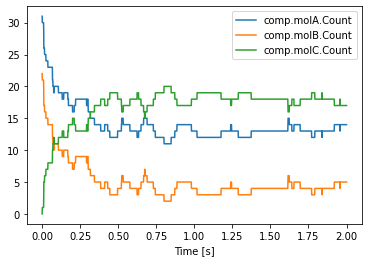

In [11]:
plt.plot(saver.time[0], saver.data[0])
plt.legend(saver.labels)
plt.xlabel('Time [s]')
plt.show()

If we want to look at the average across all runs, we can write:

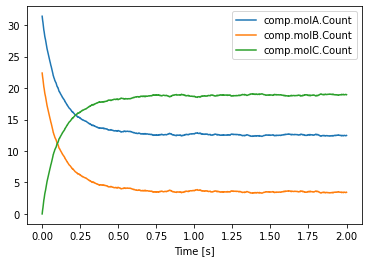

In [12]:
plt.plot(saver.time[0], np.mean(saver.data, axis=0))
plt.legend(saver.labels)
plt.xlabel('Time [s]')
plt.show()

`np.mean(saver.data, axis=0)` computes the average across the first dimension (`axis=0`), the one of runs.

We can also simulate new runs, they will simply be added to the saver. For instance, we can run simulations in which we add 10 molecules of `molA` in the middle of the simulation:

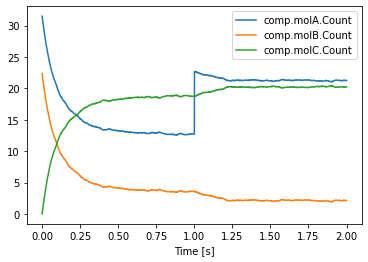

In [13]:
for i in range(NITER):
    sim.newRun()

    sim.comp.molA.Conc = 31.4e-6
    sim.comp.molB.Conc = 22.3e-6

    sim.run(1.0)

    sim.comp.molA.Count += 10

    sim.run(2.0)

plt.plot(saver.time[0], np.mean(saver.data[NITER:], axis=0))
plt.legend(saver.labels)
plt.xlabel('Time [s]')
plt.show()

instead of `saver.data`, we use `saver.data[NITER:]` which returns the data relative to all runs whose index is higher than or equal to `NITER`.

We can also run a single simulation in which `molA` is clamped for 0.5s:

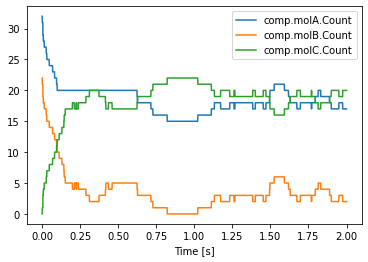

In [14]:
sim.newRun()
sim.comp.molA.Conc = 31.4e-6
sim.comp.molB.Conc = 22.3e-6

sim.run(0.1)

sim.comp.molA.Clamped = True

sim.run(0.6)

sim.comp.molA.Clamped = False

sim.run(2.0)
    
plt.plot(saver.time[0], saver.data[-1])
plt.legend(saver.labels)
plt.xlabel('Time [s]')
plt.show()

`saver.data[-1]` returns the data relative to the last run.

Finally, it is totally possible to run longer simulations. Here we run a simulation for 12s, switching on and off reactions:

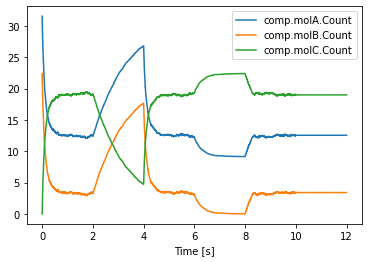

In [15]:
for i in range(NITER):
    sim.newRun()
    sim.comp.molA.Conc = 31.4e-6
    sim.comp.molB.Conc = 22.3e-6

    sim.run(2.0)

    sim.comp.r1['fwd'].Active = False
    sim.run(4.0)
    sim.comp.r1['fwd'].Active = True
    sim.run(6.0)
    sim.comp.r1['bkw'].Active = False
    sim.run(8.0)
    sim.comp.r1['bkw'].Active = True
    sim.run(10.0)
    sim.comp.r1['fwd'].Active = False
    sim.comp.r1['bkw'].Active = False
    sim.run(12.0)

plt.plot(saver.time[-1], np.mean(saver.data[-NITER:], axis=0))
plt.legend(saver.labels)
plt.xlabel('Time [s]')
plt.show()

Since the time points are different for these last runs, we need to take care of using `saver.time[-1]` (which returns the time points of the last run) instead of `saver.time[0]`. The data is accessed with `saver.data[-NITER:]` which returns the last `NITER` runs.